In [235]:
import osqp
import cvxpy as cp
import numpy as np

import scipy as sp
from scipy import sparse

import matplotlib.pyplot as plt
from scipy.linalg import hankel

import gym
import mujoco_py
from gym import wrappers
from IPython import display
plt.rcParams["figure.figsize"] = (18,6)
%matplotlib inline

## Data Collection

In [236]:
env = gym.make('InvertedPendulum-v4', render_mode='rgb_array')
"""
    Timestep for InvertedPendelum-v4 is 0.02
"""
obs = env.reset()

ud = np.array([])
yd = np.array([])
done = False

Tini = 4
n = 4
N = 5
m = 1
p = 4
T = (m+1)*(Tini + N + n) - 1

for i in range(T):
    action = env.action_space.sample()
    obs, rew, done, info, _ = env.step(action)
    ud = np.append(ud,action)
    yd = np.append(yd,obs)

env.close()

print(f'yd shape : {yd.shape}   ud shape : {ud.shape}')


yd shape : (100,)   ud shape : (25,)


In [237]:
L = Tini + N + n
H = hankel(ud[0:L], ud[L-1:])
print(f'H has rank {np.linalg.matrix_rank(H)} and shape {H.shape}')

H has rank 13 and shape (13, 13)


In [238]:
L = Tini + N

U = hankel(ud[0:L], ud[L-1:])

Y = np.zeros((L*p, T-L+1))
for i in range(0,T-L+1):
    Y[:,i] = yd[p*i:p*(L+i)]

Up = U[0:Tini, :]
Uf = U[Tini:, :]
print(f'U = {U.shape}, Up = {Up.shape}, Uf = {Uf.shape}')

Yp = Y[0:p*Tini, :]
Yf = Y[p*Tini:, :]
print(f'Y = {Y.shape}, Yp = {Yp.shape}, Yf = {Yf.shape}')

u_ini = ud[:Tini]
y_ini = yd[:p*Tini]
print(f'u ini : {u_ini}\ny ini : {y_ini}')


U = (9, 17), Up = (4, 17), Uf = (5, 17)
Y = (36, 17), Yp = (16, 17), Yf = (20, 17)
u ini : [-0.84205693 -1.89704847 -1.71460974  2.62509346]
y ini : [ 0.00348644  0.01752279 -0.28265196  0.65272464 -0.02037325  0.07231489
 -0.90878922  2.07626992 -0.06787391  0.18025783 -1.46428661  3.31691891
 -0.10897449  0.27355902 -0.59826756  1.40643223]


## Solver

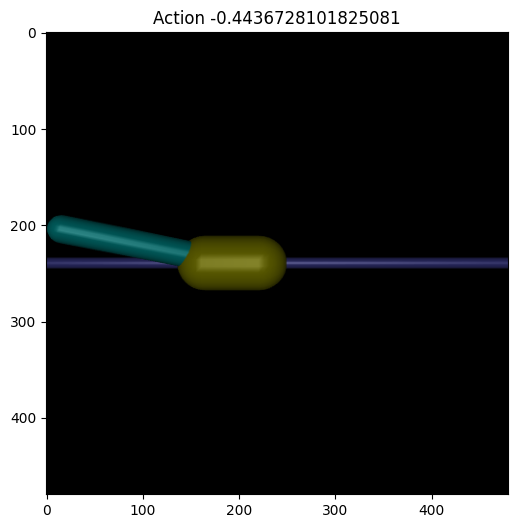

In [239]:
g = cp.Variable(T - Tini - N + 1)
u = cp.Variable(N)
y = cp.Variable(N*p)
sig_y = cp.Variable(p*Tini)

Q = np.eye(N*p)
R = np.eye(N)*0.1

cost = cp.quad_form(y, Q) + cp.quad_form(u,R) + cp.norm1(g) + cp.norm1(sig_y)*10

env = gym.make('InvertedPendulum-v4', render_mode='rgb_array')
obs = env.reset()
yT = [*y_ini]
uT = [*u_ini]

for i in range(30):

  constraints = [
    Up @ g == u_ini,
    Yp @ g == y_ini + sig_y,
    Uf @ g == u,
    Yf @ g == y,
    cp.abs(u) <= 3
  ]

  prob = cp.Problem(cp.Minimize(cost), constraints)
  prob.solve(solver=cp.OSQP, verbose=False)
  action = prob.variables()[1].value[0]

  plt.title(f"Action {action}")
  plt.imshow(env.render())
  display.display(plt.gcf())    
  display.clear_output(wait=True)

  obs,_,_,_,_ = env.step([action])
  yT = np.append(yT, obs)
  uT = np.append(uT, action)
    
  u_ini = uT[-Tini:]
  y_ini = yT[-p*Tini:]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(136,)


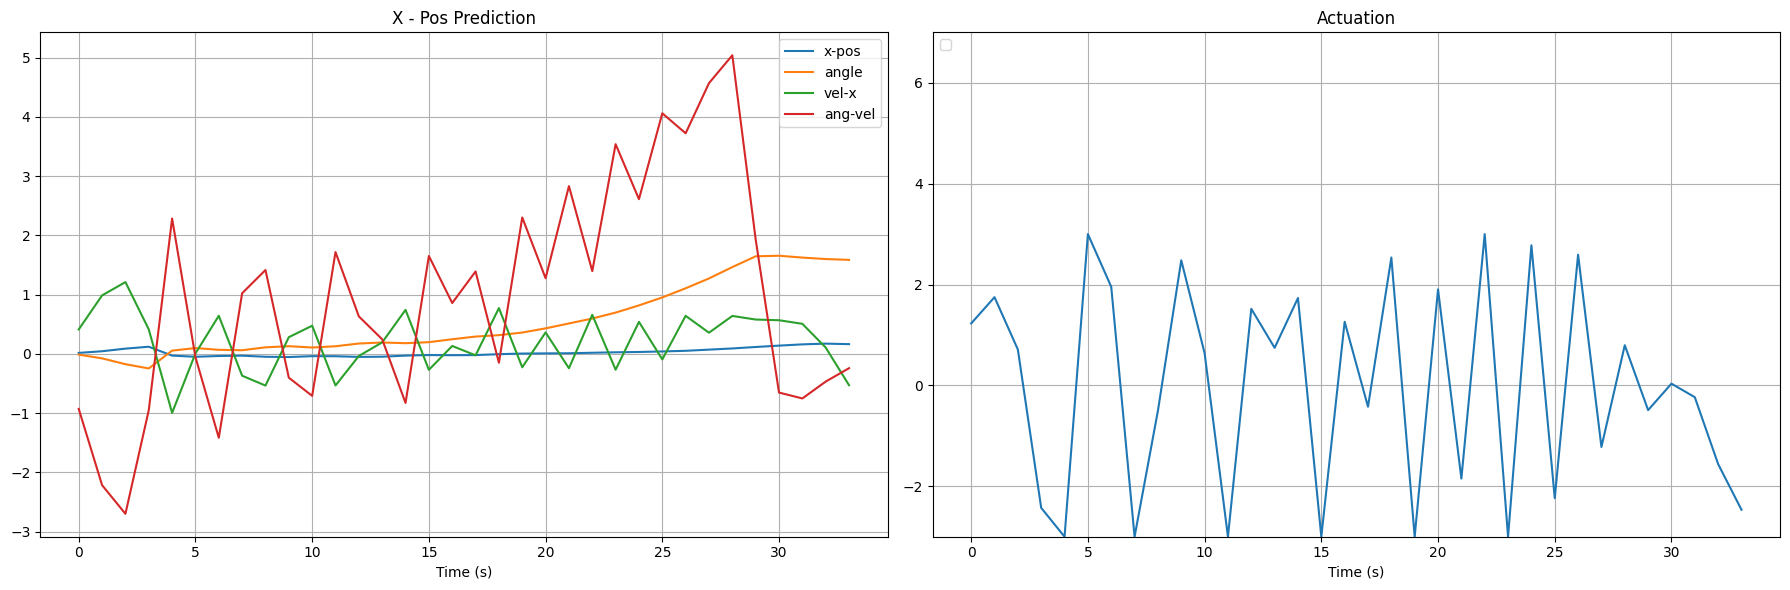

In [ ]:
# time = np.array(list(range(0,N)))
# y = prob.variables()[0].value
# u = prob.variables()[1].value
yT = np.array(yT)
print(yT.shape)
yT = yT.reshape((34,4))
plt.subplot(1,2,1)
plt.plot(range(0,34), yT, label=['x-pos', 'angle', 'vel-x', 'ang-vel'])
plt.legend(loc="upper right")
plt.xlabel('Time (s)')
plt.title("X - Pos Prediction")
# plt.ylim((-3,7))
plt.grid('on')
plt.tight_layout()

plt.subplot(1,2,2)
plt.plot(range(0,34), uT)
plt.legend(loc="upper left")
plt.xlabel('Time (s)')
plt.title("Actuation")
plt.ylim((-3,7))
plt.grid('on')
plt.tight_layout()

plt.show()